# IAU Projekt

# Fáza 2 - predspracovanie údajov

## Projekt vypracovali:

* Peter Smreček - 50%
* Anetta Langová - 50%

V tejto fáze sa od Vás očakáva:
* Realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada vo formáte csv alebo tsv, kde jedno pozorovanie musí byť opísané jedným riadkom.
* V 3. fáze budeme pracovať s algoritmami strojového učenia, ktorých implementácia v scikit-learn podporuje len numerické dáta. To vedie k tomu že treba niečo spraviť s nenumerickými dátami.
* Replikovateľnosť predspracovania na trénovacej a testovacej množine dát.

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby. Bodovanie znovu za EDA už nebudeme, zmeny ale zdokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa vlastnej potreby.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats

import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## Predspracovanie z fázy 1

In [2]:
labor = pd.read_csv("046/labor.csv", sep='\t')
labor.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
labor = labor.drop(["index", "name"], axis=1)
smoker_encoding = {"Y": 1, "N": 0, "yes": 1, "no": 0}
labor["smoker"].replace(smoker_encoding, inplace=True)

profiles = pd.read_csv("046/profiles.csv", sep='\t')
profiles.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
profiles = profiles.drop(["index"], axis=1)
profiles["race"].replace({"black": "Black", "white": "White", "blsck": "Black"}, inplace=True)
profiles["birthdate"] = pd.to_datetime(profiles['birthdate'], utc=False)

merged = pd.merge(profiles, labor, how='outer', on='ssn')
merged = merged.drop(["ssn"], axis=1)

## Základné úpravy dát pred začiatkom druhej fázy

### Kódovanie kategorických atribútov pre strojové učenie

#### 1. race

In [3]:
ce_ordinal = ce.OrdinalEncoder(cols=['race'])
merged = ce_ordinal.fit_transform(merged)

C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#### 2. residence

Tento atribút je až príliš a nepotrebne detailný pre spracovanie dát, preto transformujeme využitím generalizácie bydlisko na štát. Aby sme z celého textu bydliska získali štát, je potrebné NLP a to pomocou regex výrazov. Na obídenie nesprávnych výsledkov využijeme fakt, že názov štátu je zapísaný ako skratka s PSČ.

Počet výsledkov je zhodný s počtom záznamov v datasete a po manuálnej kontrole všetky výsledky patria nejakej krajine s PSČ.

In [4]:
for i in merged['residence'].index:
    country_code = re.findall('[A-Z]{2} [0-9]{5}', str(merged['residence'][i]))[0]
    merged.at[i, 'state']=re.findall('[A-Z]{2}', country_code)[0]
len(merged['state'].value_counts())

54

Počet unikátnych krajín je správny, keď vychádzame z pravidiel v USA. 54 štátov dokopy predstavuje 51 štátov v USA plus 3 "military states" (AA, AE, AP).

<AxesSubplot:>

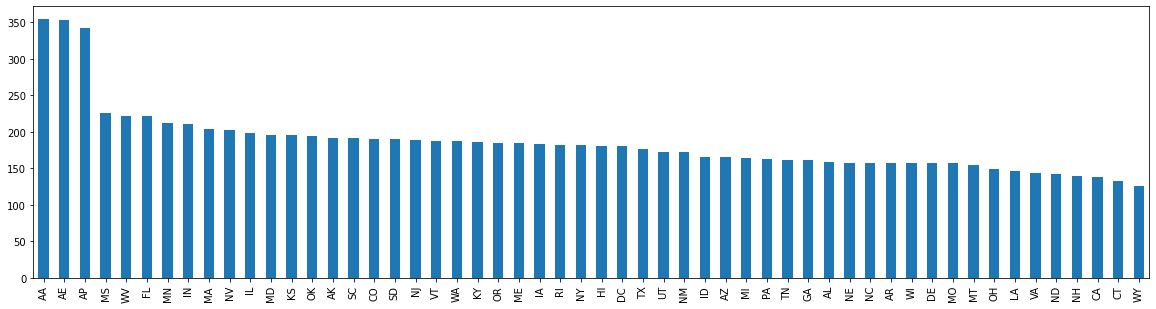

In [5]:
merged['state'].value_counts().plot(kind='bar', figsize=(20, 5))

In [6]:
ce_ordinal = ce.OrdinalEncoder(cols=['state'])
merged = ce_ordinal.fit_transform(merged)

#### 3. blood_group

In [7]:
ce_ordinal = ce.OrdinalEncoder(cols=['blood_group'])
merged = ce_ordinal.fit_transform(merged)

#### 4. sex

In [8]:
ce_OHE = ce.OneHotEncoder(cols=['sex'], use_cat_names=True)
merged = ce_OHE.fit_transform(merged)

#### 5. birthday

In [9]:
def frombirthtoage(born):
    now = datetime.date.today()
    return now.year - born.year - ((now.month, now.day) < (born.month, born.day))
ages = merged['birthdate'].apply(lambda d: frombirthtoage(d))
merged = merged.assign(age=ages.values)

<AxesSubplot:>

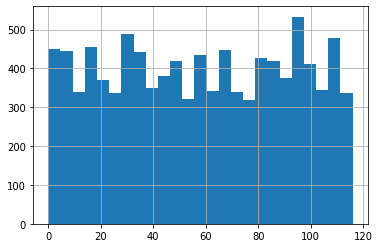

In [10]:
merged.age.hist(bins=25)

#### 6. relationship

In [11]:
ce_ordinal = ce.OrdinalEncoder(cols=['relationship'])
merged = ce_ordinal.fit_transform(merged)

In [12]:
merged.head()

,race,residence,job,birthdate,company,blood_group,sex_F,sex_M,name,weight,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
0,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,0,Laura Valentine,68.64852,...,11.27999,0.0,44.47642,8.86713,0,1,26.77151,5.62532,1,14
1,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,0,Laura Valentine,39.27363,...,11.65206,1.0,57.12059,10.57140,0,2,38.28069,6.59275,1,14
2,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,0,Laura Valentine,61.21115,...,9.13539,1.0,16.95110,7.30150,0,3,52.93857,8.58363,1,14
3,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,0,Laura Valentine,121.34568,...,8.46192,0.0,63.86999,8.47060,0,3,48.94005,7.28386,1,14
4,2,"2246 Tammy Cliffs Apt. 057\nNorth Kim, MI 55878","Investment banker, operational",1971-05-20,Mcdonald-White,2,1,0,Angela Sullivan,107.36307,...,5.96198,1.0,42.66862,6.25355,0,4,60.53571,9.03697,2,50


## 1. Integrácia a čistenie dát (5b)

Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### Chýbajúce dáta

In [13]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   race          10002 non-null  int32         
 1   residence     10002 non-null  object        
 2   job           10002 non-null  object        
 3   birthdate     10002 non-null  datetime64[ns]
 4   company       10002 non-null  object        
 5   blood_group   10002 non-null  int32         
 6   sex_F         10002 non-null  int64         
 7   sex_M         10002 non-null  int64         
 8   name          10002 non-null  object        
 9   weight        10002 non-null  float64       
 10  hemoglobin    9972 non-null   float64       
 11  alp           9972 non-null   float64       
 12  etytr         9972 non-null   float64       
 13  alt           9971 non-null   float64       
 14  erytrocyty    9972 non-null   float64       
 15  hbver         9972 non-null   float6

In [14]:
merged.shape[0] - merged.dropna().shape[0]

330

In [15]:
merged.isnull().sum()

race             0
residence        0
job              0
birthdate        0
company          0
blood_group      0
sex_F            0
sex_M            0
name             0
weight           0
hemoglobin      30
alp             30
etytr           30
alt             31
erytrocyty      30
hbver           30
hematokrit      30
indicator        0
er-cv           30
leukocyty       30
smoker           0
relationship     0
ast             30
trombocyty      30
state            0
age              0
dtype: int64

In [16]:
merged.isnull().sum().sum()

331

In [17]:
print("Chýbajúce dáta tvoria {:.3f}% dát".format(merged.isnull().sum().sum() / merged.shape[0] * 100))

Chýbajúce dáta tvoria 3.309% dát


#### Odstránenie pozorovaní s chýbajúcimi údajmi

In [18]:
def removeNA(merged):
    return merged.dropna()

In [19]:
merged_withoutNA = removeNA(merged)

In [20]:
merged_withoutNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   race          9672 non-null   int32         
 1   residence     9672 non-null   object        
 2   job           9672 non-null   object        
 3   birthdate     9672 non-null   datetime64[ns]
 4   company       9672 non-null   object        
 5   blood_group   9672 non-null   int32         
 6   sex_F         9672 non-null   int64         
 7   sex_M         9672 non-null   int64         
 8   name          9672 non-null   object        
 9   weight        9672 non-null   float64       
 10  hemoglobin    9672 non-null   float64       
 11  alp           9672 non-null   float64       
 12  etytr         9672 non-null   float64       
 13  alt           9672 non-null   float64       
 14  erytrocyty    9672 non-null   float64       
 15  hbver         9672 non-null   float64

<AxesSubplot:>

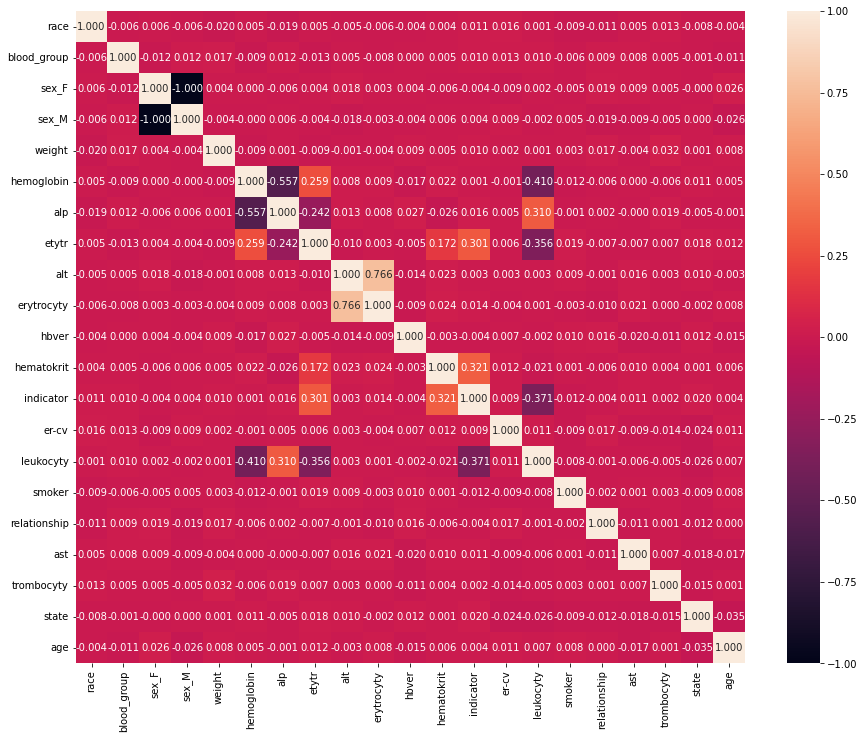

In [21]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged.corr(), ax=ax, annot=True, fmt=".3f")

<AxesSubplot:>

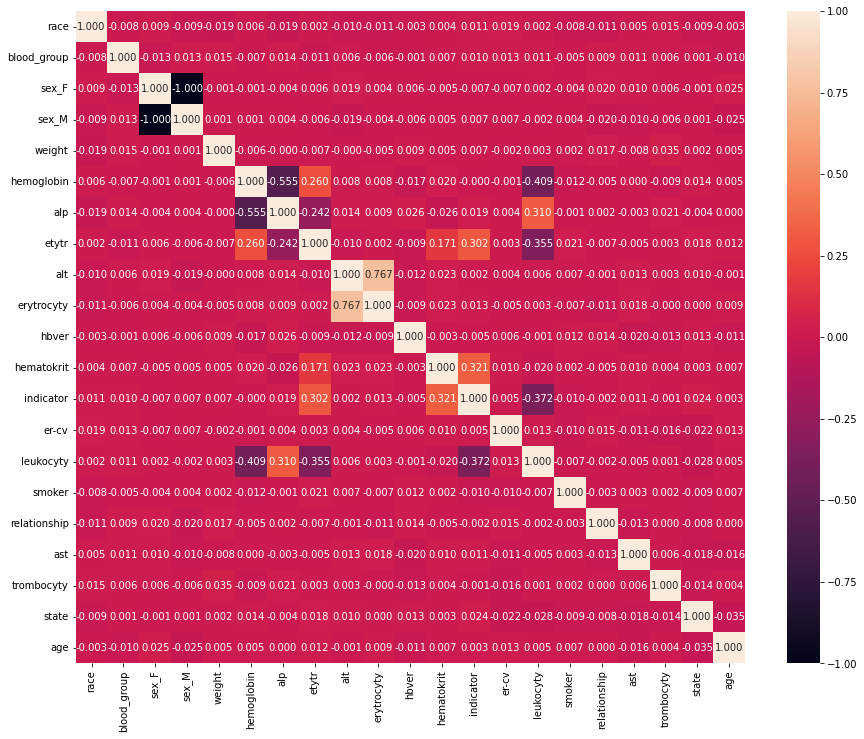

In [22]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_withoutNA.corr(), ax=ax, annot=True, fmt=".3f")

Po odstránení chýbajúcich hodnôt sa nič významné nezmienilo

#### Nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN

In [23]:
def getNAcols(merged):
    return merged.columns[merged.isnull().any()].tolist()

In [24]:
# na_cols = ["hemoglobin", "alp", "etytr", "alt", "erytrocyty", "hbver", "hematokrit", "er-cv", "leukocyty", "ast", "trombocyty"] 
na_cols = getNAcols(merged)

In [25]:
def replaceNaN(original_merged, strategy, na_cols):
    new_merged = original_merged.copy()
    if strategy == "kNN":
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
#         imp_strategy = KNNImputer()
    elif strategy == "mean" or strategy == "median":    
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
    else:
        raise Exception("Chybny argument strategy")
    for col in na_cols:
        new_merged[col] = imp_strategy.fit_transform(new_merged[[col]])
    return new_merged

##### Nahradenie priemerom

In [26]:
merged_mean = replaceNaN(merged, "mean", na_cols)
merged_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   race          10002 non-null  int32         
 1   residence     10002 non-null  object        
 2   job           10002 non-null  object        
 3   birthdate     10002 non-null  datetime64[ns]
 4   company       10002 non-null  object        
 5   blood_group   10002 non-null  int32         
 6   sex_F         10002 non-null  int64         
 7   sex_M         10002 non-null  int64         
 8   name          10002 non-null  object        
 9   weight        10002 non-null  float64       
 10  hemoglobin    10002 non-null  float64       
 11  alp           10002 non-null  float64       
 12  etytr         10002 non-null  float64       
 13  alt           10002 non-null  float64       
 14  erytrocyty    10002 non-null  float64       
 15  hbver         10002 non-null  float6

<AxesSubplot:>

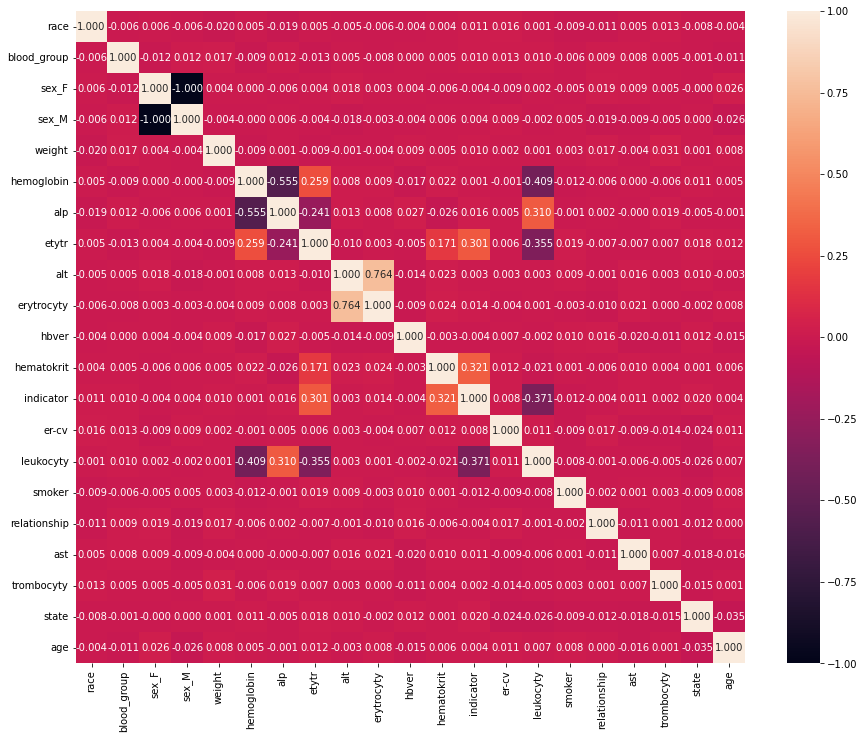

In [27]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_mean.corr(), ax=ax, annot=True, fmt=".3f")

##### Nahradenie mediánom

In [28]:
merged_median = replaceNaN(merged, "median", na_cols)
merged_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   race          10002 non-null  int32         
 1   residence     10002 non-null  object        
 2   job           10002 non-null  object        
 3   birthdate     10002 non-null  datetime64[ns]
 4   company       10002 non-null  object        
 5   blood_group   10002 non-null  int32         
 6   sex_F         10002 non-null  int64         
 7   sex_M         10002 non-null  int64         
 8   name          10002 non-null  object        
 9   weight        10002 non-null  float64       
 10  hemoglobin    10002 non-null  float64       
 11  alp           10002 non-null  float64       
 12  etytr         10002 non-null  float64       
 13  alt           10002 non-null  float64       
 14  erytrocyty    10002 non-null  float64       
 15  hbver         10002 non-null  float6

<AxesSubplot:>

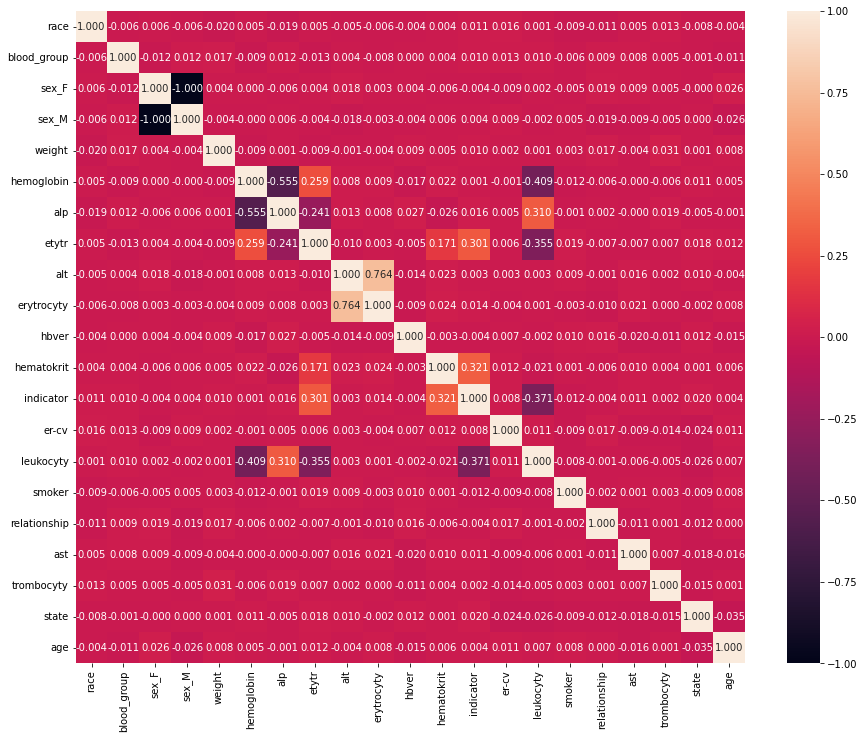

In [29]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_median.corr(), ax=ax, annot=True, fmt=".3f")

##### Nahradenie kNN

In [30]:
merged_knn = replaceNaN(merged, "mean", na_cols)
merged_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   race          10002 non-null  int32         
 1   residence     10002 non-null  object        
 2   job           10002 non-null  object        
 3   birthdate     10002 non-null  datetime64[ns]
 4   company       10002 non-null  object        
 5   blood_group   10002 non-null  int32         
 6   sex_F         10002 non-null  int64         
 7   sex_M         10002 non-null  int64         
 8   name          10002 non-null  object        
 9   weight        10002 non-null  float64       
 10  hemoglobin    10002 non-null  float64       
 11  alp           10002 non-null  float64       
 12  etytr         10002 non-null  float64       
 13  alt           10002 non-null  float64       
 14  erytrocyty    10002 non-null  float64       
 15  hbver         10002 non-null  float6

<AxesSubplot:>

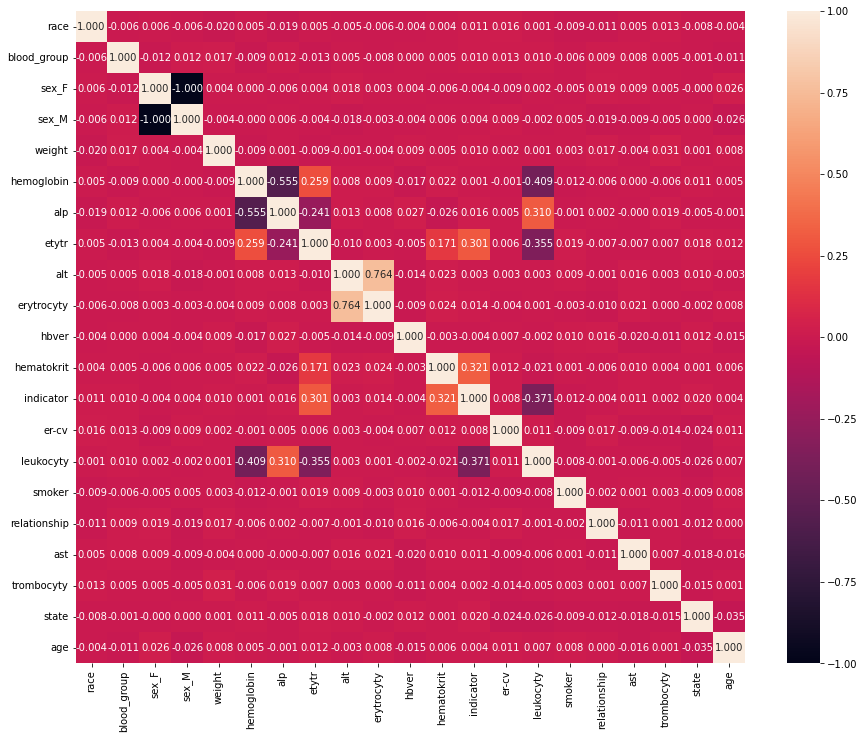

In [31]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_knn.corr(), ax=ax, annot=True, fmt=".3f")

In [32]:
merged_mean.corr() - merged_median.corr()

,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
race,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.738929e-05,-0.000023,-1.375642e-06,-0.000094,3.882981e-06,...,-4.790817e-05,0.000000e+00,-1.995276e-06,0.000107,0.000000e+00,0.000000e+00,-0.000003,-4.252607e-07,0.000000e+00,0.000000e+00
blood_group,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102259e-05,-0.000016,-3.656487e-06,0.000106,-1.818350e-06,...,3.354586e-05,0.000000e+00,-1.819620e-06,-0.000070,0.000000e+00,0.000000e+00,-0.000003,-3.813291e-07,0.000000e+00,0.000000e+00
sex_F,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.229058e-06,0.000027,-5.841383e-06,-0.000155,-3.102235e-06,...,1.784832e-06,0.000000e+00,-4.711496e-07,0.000058,0.000000e+00,0.000000e+00,-0.000004,2.167064e-07,0.000000e+00,0.000000e+00
sex_M,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.229058e-06,-0.000027,5.841383e-06,0.000155,3.102235e-06,...,-1.784832e-06,0.000000e+00,4.711496e-07,-0.000058,0.000000e+00,0.000000e+00,0.000004,-2.167064e-07,0.000000e+00,0.000000e+00
weight,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.202691e-06,0.000002,-4.009885e-06,0.000295,1.554878e-06,...,-6.753629e-06,0.000000e+00,1.326511e-06,-0.000107,0.000000e+00,0.000000e+00,-0.000002,-7.557277e-07,0.000000e+00,0.000000e+00
hemoglobin,3.738929e-05,2.102259e-05,2.229058e-06,-2.229058e-06,1.202691e-06,0.000000e+00,0.000012,-1.187615e-05,0.000190,-2.466474e-05,...,-5.124845e-05,-2.942349e-05,2.852346e-05,-0.000054,-3.133367e-05,5.716817e-07,0.000029,6.943692e-07,-9.405754e-06,-2.082075e-05
alp,-2.328802e-05,-1.603580e-05,2.685806e-05,-2.685806e-05,2.156200e-06,1.220455e-05,0.000000,1.879684e-05,-0.000240,-9.477205e-06,...,-1.475961e-05,-3.155563e-05,-4.514591e-05,0.000006,2.152900e-05,-4.514798e-06,-0.000005,-2.882502e-06,2.322626e-06,1.371215e-05
etytr,-1.375642e-06,-3.656487e-06,-5.841383e-06,5.841383e-06,-4.009885e-06,-1.187615e-05,0.000019,0.000000e+00,-0.000012,-9.329813e-06,...,9.630852e-06,-4.376556e-06,7.398149e-06,-0.000179,4.513961e-08,8.839973e-08,-0.000013,1.556074e-06,-8.115123e-06,-1.383934e-06
alt,-9.435332e-05,1.056895e-04,-1.547290e-04,1.547290e-04,2.951931e-04,1.901618e-04,-0.000240,-1.196076e-05,0.000000,8.005797e-05,...,9.022849e-05,2.466538e-04,1.408327e-04,-0.000304,2.113607e-04,-2.422657e-04,0.000209,1.234114e-04,-4.386690e-06,3.199970e-04
erytrocyty,3.882981e-06,-1.818350e-06,-3.102235e-06,3.102235e-06,1.554878e-06,-2.466474e-05,-0.000009,-9.329813e-06,0.000080,0.000000e+00,...,-1.081691e-05,-4.958809e-06,4.776931e-06,-0.000182,4.863347e-08,7.648487e-06,0.000008,-2.437052e-06,1.027220e-05,-2.227255e-06


In [33]:
merged_mean.corr() - merged_knn.corr()

,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
race,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blood_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sex_F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sex_M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hemoglobin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
etytr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
erytrocyty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
merged_median.corr() - merged_knn.corr()

,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
race,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.738929e-05,0.000023,1.375642e-06,0.000094,-3.882981e-06,...,4.790817e-05,0.000000e+00,1.995276e-06,-0.000107,0.000000e+00,0.000000e+00,0.000003,4.252607e-07,0.000000e+00,0.000000e+00
blood_group,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.102259e-05,0.000016,3.656487e-06,-0.000106,1.818350e-06,...,-3.354586e-05,0.000000e+00,1.819620e-06,0.000070,0.000000e+00,0.000000e+00,0.000003,3.813291e-07,0.000000e+00,0.000000e+00
sex_F,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.229058e-06,-0.000027,5.841383e-06,0.000155,3.102235e-06,...,-1.784832e-06,0.000000e+00,4.711496e-07,-0.000058,0.000000e+00,0.000000e+00,0.000004,-2.167064e-07,0.000000e+00,0.000000e+00
sex_M,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.229058e-06,0.000027,-5.841383e-06,-0.000155,-3.102235e-06,...,1.784832e-06,0.000000e+00,-4.711496e-07,0.000058,0.000000e+00,0.000000e+00,-0.000004,2.167064e-07,0.000000e+00,0.000000e+00
weight,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.202691e-06,-0.000002,4.009885e-06,-0.000295,-1.554878e-06,...,6.753629e-06,0.000000e+00,-1.326511e-06,0.000107,0.000000e+00,0.000000e+00,0.000002,7.557277e-07,0.000000e+00,0.000000e+00
hemoglobin,-3.738929e-05,-2.102259e-05,-2.229058e-06,2.229058e-06,-1.202691e-06,0.000000e+00,-0.000012,1.187615e-05,-0.000190,2.466474e-05,...,5.124845e-05,2.942349e-05,-2.852346e-05,0.000054,3.133367e-05,-5.716817e-07,-0.000029,-6.943692e-07,9.405754e-06,2.082075e-05
alp,2.328802e-05,1.603580e-05,-2.685806e-05,2.685806e-05,-2.156200e-06,-1.220455e-05,0.000000,-1.879684e-05,0.000240,9.477205e-06,...,1.475961e-05,3.155563e-05,4.514591e-05,-0.000006,-2.152900e-05,4.514798e-06,0.000005,2.882502e-06,-2.322626e-06,-1.371215e-05
etytr,1.375642e-06,3.656487e-06,5.841383e-06,-5.841383e-06,4.009885e-06,1.187615e-05,-0.000019,0.000000e+00,0.000012,9.329813e-06,...,-9.630852e-06,4.376556e-06,-7.398149e-06,0.000179,-4.513961e-08,-8.839973e-08,0.000013,-1.556074e-06,8.115123e-06,1.383934e-06
alt,9.435332e-05,-1.056895e-04,1.547290e-04,-1.547290e-04,-2.951931e-04,-1.901618e-04,0.000240,1.196076e-05,0.000000,-8.005797e-05,...,-9.022849e-05,-2.466538e-04,-1.408327e-04,0.000304,-2.113607e-04,2.422657e-04,-0.000209,-1.234114e-04,4.386690e-06,-3.199970e-04
erytrocyty,-3.882981e-06,1.818350e-06,3.102235e-06,-3.102235e-06,-1.554878e-06,2.466474e-05,0.000009,9.329813e-06,-0.000080,0.000000e+00,...,1.081691e-05,4.958809e-06,-4.776931e-06,0.000182,-4.863347e-08,-7.648487e-06,-0.000008,2.437052e-06,-1.027220e-05,2.227255e-06


### Vychýlené dáta

In [35]:
def onlyNumCols(merged_withoutNA):
    return merged_withoutNA.drop(["residence", "job", "company", "name", "birthdate"], axis=1)

In [36]:
merged_num_only = onlyNumCols(merged_withoutNA)

In [37]:
merged_num_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   race          9672 non-null   int32  
 1   blood_group   9672 non-null   int32  
 2   sex_F         9672 non-null   int64  
 3   sex_M         9672 non-null   int64  
 4   weight        9672 non-null   float64
 5   hemoglobin    9672 non-null   float64
 6   alp           9672 non-null   float64
 7   etytr         9672 non-null   float64
 8   alt           9672 non-null   float64
 9   erytrocyty    9672 non-null   float64
 10  hbver         9672 non-null   float64
 11  hematokrit    9672 non-null   float64
 12  indicator     9672 non-null   float64
 13  er-cv         9672 non-null   float64
 14  leukocyty     9672 non-null   float64
 15  smoker        9672 non-null   int64  
 16  relationship  9672 non-null   int32  
 17  ast           9672 non-null   float64
 18  trombocyty    9672 non-null

race               AxesSubplot(0.125,0.787927;0.227941x0.0920732)
blood_group     AxesSubplot(0.398529,0.787927;0.227941x0.0920732)
sex_F           AxesSubplot(0.672059,0.787927;0.227941x0.0920732)
sex_M              AxesSubplot(0.125,0.677439;0.227941x0.0920732)
weight          AxesSubplot(0.398529,0.677439;0.227941x0.0920732)
hemoglobin      AxesSubplot(0.672059,0.677439;0.227941x0.0920732)
alp                AxesSubplot(0.125,0.566951;0.227941x0.0920732)
etytr           AxesSubplot(0.398529,0.566951;0.227941x0.0920732)
alt             AxesSubplot(0.672059,0.566951;0.227941x0.0920732)
erytrocyty         AxesSubplot(0.125,0.456463;0.227941x0.0920732)
hbver           AxesSubplot(0.398529,0.456463;0.227941x0.0920732)
hematokrit      AxesSubplot(0.672059,0.456463;0.227941x0.0920732)
indicator          AxesSubplot(0.125,0.345976;0.227941x0.0920732)
er-cv           AxesSubplot(0.398529,0.345976;0.227941x0.0920732)
leukocyty       AxesSubplot(0.672059,0.345976;0.227941x0.0920732)
smoker    

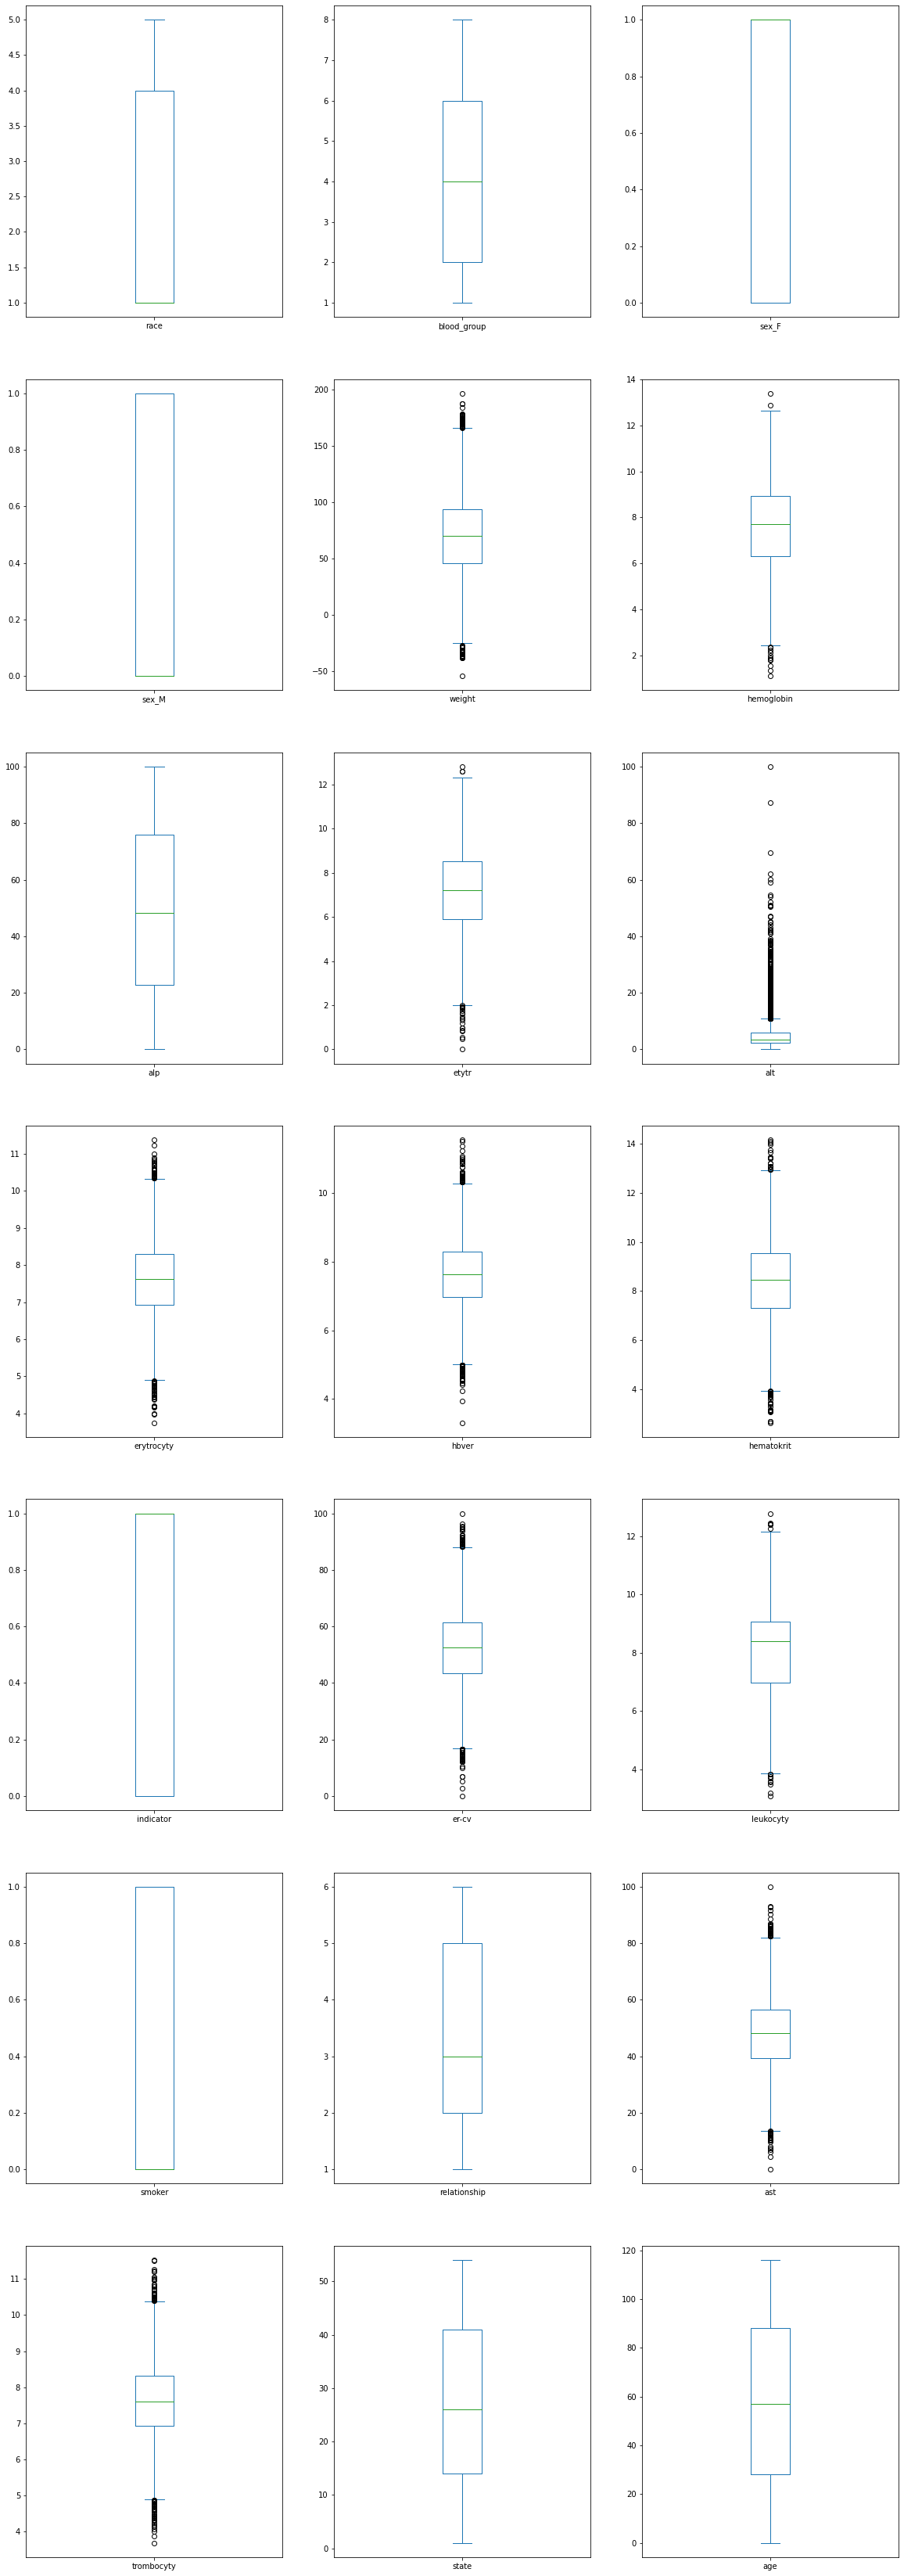

In [38]:
merged_num_only.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

#### Identifikácia vychýlených hodnôt

In [39]:
def identify_outliers(merged):
    suma = 0;
    for col in merged.columns:
        q25, q75 = percentile(merged[col], 25), percentile(merged[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = merged[((merged[col] < lower) | (merged[col] > upper))] 
        print(col, 'Identified outliers: %d' % len(outliers))
        suma += len(outliers)
    print('Sum of identified outliers: %d' % suma)

In [40]:
identify_outliers(merged_num_only)

race Identified outliers: 0
blood_group Identified outliers: 0
sex_F Identified outliers: 0
sex_M Identified outliers: 0
weight Identified outliers: 53
hemoglobin Identified outliers: 13
alp Identified outliers: 0
etytr Identified outliers: 23
alt Identified outliers: 767
erytrocyty Identified outliers: 65
hbver Identified outliers: 73
hematokrit Identified outliers: 48
indicator Identified outliers: 0
er-cv Identified outliers: 64
leukocyty Identified outliers: 14
smoker Identified outliers: 0
relationship Identified outliers: 0
ast Identified outliers: 54
trombocyty Identified outliers: 73
state Identified outliers: 0
age Identified outliers: 0
Sum of identified outliers: 1247


#### Odstránenie vychýlených (odľahlých) pozorovaní

In [41]:
def remove_outliers(merged):
    newMerged = merged.copy()
    for col in newMerged.columns:
        q25, q75 = percentile(newMerged[col], 25), percentile(newMerged[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        newMerged = newMerged[((newMerged[col] >= lower) & (newMerged[col] <= upper))] 
    return newMerged

In [42]:
merged_withoutOut = remove_outliers(merged_num_only)
merged_withoutOut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8491 entries, 0 to 10001
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   race          8491 non-null   int32  
 1   blood_group   8491 non-null   int32  
 2   sex_F         8491 non-null   int64  
 3   sex_M         8491 non-null   int64  
 4   weight        8491 non-null   float64
 5   hemoglobin    8491 non-null   float64
 6   alp           8491 non-null   float64
 7   etytr         8491 non-null   float64
 8   alt           8491 non-null   float64
 9   erytrocyty    8491 non-null   float64
 10  hbver         8491 non-null   float64
 11  hematokrit    8491 non-null   float64
 12  indicator     8491 non-null   float64
 13  er-cv         8491 non-null   float64
 14  leukocyty     8491 non-null   float64
 15  smoker        8491 non-null   int64  
 16  relationship  8491 non-null   int32  
 17  ast           8491 non-null   float64
 18  trombocyty    8491 non-null

<AxesSubplot:>

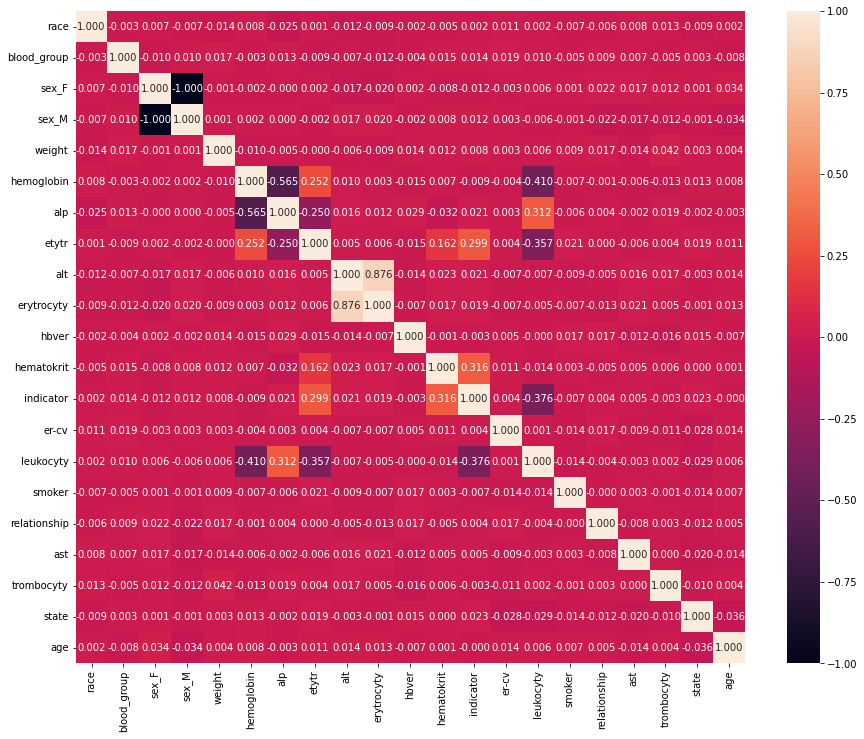

In [43]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_withoutOut.corr(), ax=ax, annot=True, fmt=".3f")

In [44]:
merged_num_only.corr() - merged_withoutOut.corr()

,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
race,0.000000,-0.004696,2.015830e-03,-2.015830e-03,-0.004432,-0.001747,0.006695,0.000955,0.001687,-0.002373,...,0.008911,0.008991,0.007788,-0.000483,-0.001143,-0.004258,-0.003259,0.001527,0.000147,-0.004707
blood_group,-0.004696,0.000000,-3.407330e-03,3.407330e-03,-0.001360,-0.003944,0.000264,-0.001637,0.013597,0.005912,...,-0.008116,-0.003622,-0.005848,0.001075,0.000129,-0.000102,0.004061,0.010113,-0.002123,-0.001941
sex_F,0.002016,-0.003407,0.000000e+00,2.220446e-16,-0.000446,0.000973,-0.004204,0.003940,0.036194,0.024462,...,0.003289,0.005325,-0.003511,-0.003769,-0.004916,-0.001657,-0.007790,-0.005598,-0.001550,-0.009049
sex_M,-0.002016,0.003407,2.220446e-16,0.000000e+00,0.000446,-0.000973,0.004204,-0.003940,-0.036194,-0.024462,...,-0.003289,-0.005325,0.003511,0.003769,0.004916,0.001657,0.007790,0.005598,0.001550,0.009049
weight,-0.004432,-0.001360,-4.458234e-04,4.458234e-04,0.000000,0.003603,0.004537,-0.006841,0.005640,0.003884,...,-0.007694,-0.001491,-0.004878,-0.003199,-0.006708,0.000535,0.006172,-0.006635,-0.001106,0.001241
hemoglobin,-0.001747,-0.003944,9.729705e-04,-9.729705e-04,0.003603,0.000000,0.009970,0.008329,-0.001933,0.004619,...,0.012156,0.008881,0.002954,0.000451,-0.004779,-0.004091,0.006024,0.004767,0.001014,-0.003354
alp,0.006695,0.000264,-4.204161e-03,4.204161e-03,0.004537,0.009970,0.000000,0.008160,-0.002437,-0.002422,...,0.006475,-0.002063,0.000455,-0.001105,0.004255,-0.001962,-0.001283,0.001428,-0.002723,0.003511
etytr,0.000955,-0.001637,3.940150e-03,-3.940150e-03,-0.006841,0.008329,0.008160,0.000000,-0.014571,-0.004100,...,0.009059,0.003646,-0.001004,0.002754,-0.000575,-0.007479,0.001272,-0.001601,-0.000829,0.000386
alt,0.001687,0.013597,3.619437e-02,-3.619437e-02,0.005640,-0.001933,-0.002437,-0.014571,0.000000,-0.109161,...,-0.000462,-0.018294,0.011257,0.012570,0.016214,0.003331,-0.003040,-0.014569,0.013160,-0.014738
erytrocyty,-0.002373,0.005912,2.446154e-02,-2.446154e-02,0.003884,0.004619,-0.002422,-0.004100,-0.109161,0.000000,...,0.005551,-0.005970,0.001579,0.007790,0.000667,0.001947,-0.002704,-0.005419,0.000921,-0.003994


#### Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

In [45]:
def replace_outliers(merged):
    newMerged = merged.copy()
    for col in newMerged.columns:
        q05, q95 = percentile(newMerged[col], 5), percentile(newMerged[col], 95)
        newMerged[col] = np.where(newMerged[col] < q05, q05, newMerged[col])
        newMerged[col] = np.where(newMerged[col] > q95, q95, newMerged[col])
    return newMerged

In [46]:
merged_replacedOut = replace_outliers(merged_num_only)

In [47]:
merged_replacedOut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   race          9672 non-null   float64
 1   blood_group   9672 non-null   float64
 2   sex_F         9672 non-null   float64
 3   sex_M         9672 non-null   float64
 4   weight        9672 non-null   float64
 5   hemoglobin    9672 non-null   float64
 6   alp           9672 non-null   float64
 7   etytr         9672 non-null   float64
 8   alt           9672 non-null   float64
 9   erytrocyty    9672 non-null   float64
 10  hbver         9672 non-null   float64
 11  hematokrit    9672 non-null   float64
 12  indicator     9672 non-null   float64
 13  er-cv         9672 non-null   float64
 14  leukocyty     9672 non-null   float64
 15  smoker        9672 non-null   float64
 16  relationship  9672 non-null   float64
 17  ast           9672 non-null   float64
 18  trombocyty    9672 non-null

In [48]:
identify_outliers(merged_replacedOut)

race Identified outliers: 0
blood_group Identified outliers: 0
sex_F Identified outliers: 0
sex_M Identified outliers: 0
weight Identified outliers: 0
hemoglobin Identified outliers: 0
alp Identified outliers: 0
etytr Identified outliers: 0
alt Identified outliers: 767
erytrocyty Identified outliers: 0
hbver Identified outliers: 0
hematokrit Identified outliers: 0
indicator Identified outliers: 0
er-cv Identified outliers: 0
leukocyty Identified outliers: 0
smoker Identified outliers: 0
relationship Identified outliers: 0
ast Identified outliers: 0
trombocyty Identified outliers: 0
state Identified outliers: 0
age Identified outliers: 0
Sum of identified outliers: 767


race               AxesSubplot(0.125,0.787927;0.227941x0.0920732)
blood_group     AxesSubplot(0.398529,0.787927;0.227941x0.0920732)
sex_F           AxesSubplot(0.672059,0.787927;0.227941x0.0920732)
sex_M              AxesSubplot(0.125,0.677439;0.227941x0.0920732)
weight          AxesSubplot(0.398529,0.677439;0.227941x0.0920732)
hemoglobin      AxesSubplot(0.672059,0.677439;0.227941x0.0920732)
alp                AxesSubplot(0.125,0.566951;0.227941x0.0920732)
etytr           AxesSubplot(0.398529,0.566951;0.227941x0.0920732)
alt             AxesSubplot(0.672059,0.566951;0.227941x0.0920732)
erytrocyty         AxesSubplot(0.125,0.456463;0.227941x0.0920732)
hbver           AxesSubplot(0.398529,0.456463;0.227941x0.0920732)
hematokrit      AxesSubplot(0.672059,0.456463;0.227941x0.0920732)
indicator          AxesSubplot(0.125,0.345976;0.227941x0.0920732)
er-cv           AxesSubplot(0.398529,0.345976;0.227941x0.0920732)
leukocyty       AxesSubplot(0.672059,0.345976;0.227941x0.0920732)
smoker    

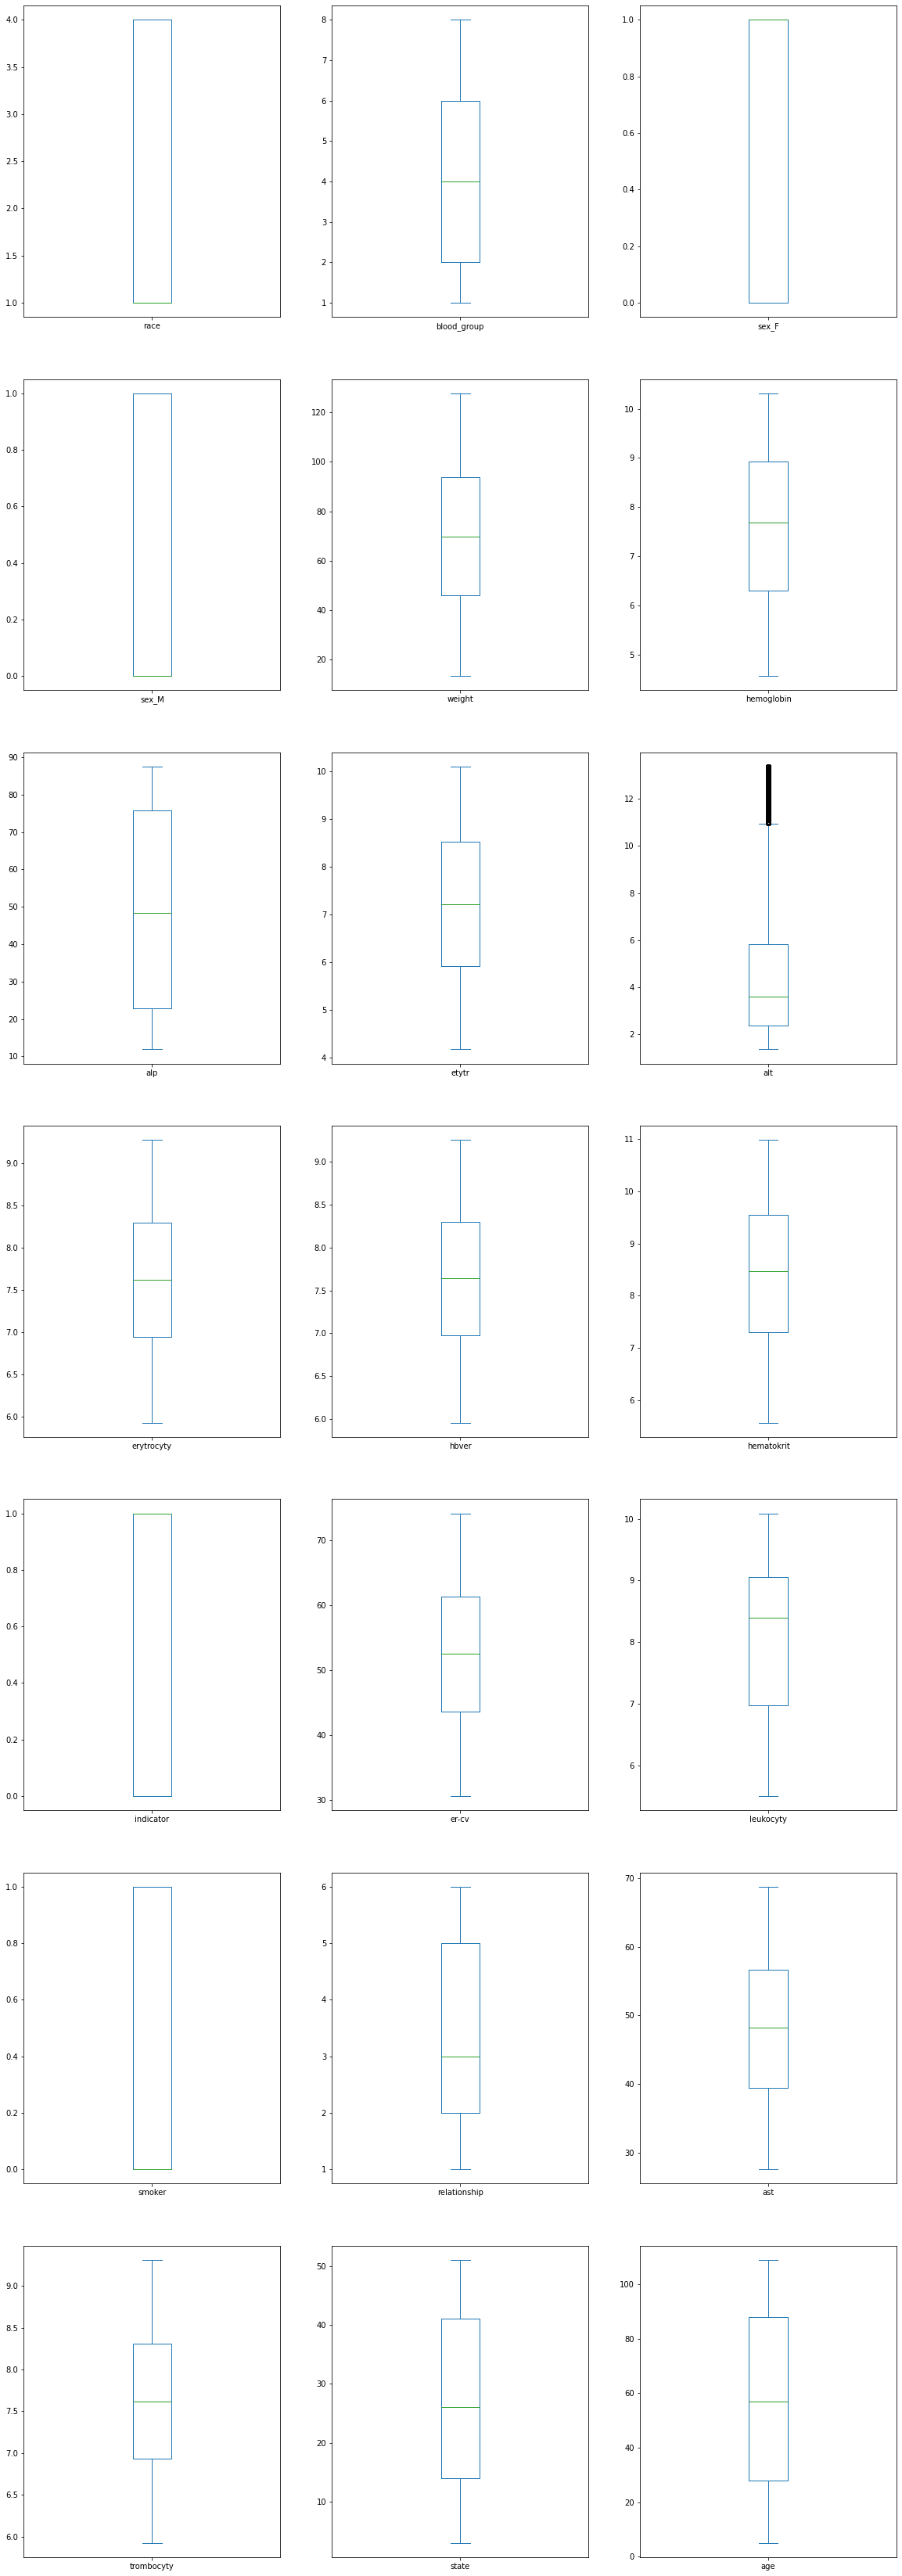

In [49]:
merged_replacedOut.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

<AxesSubplot:>

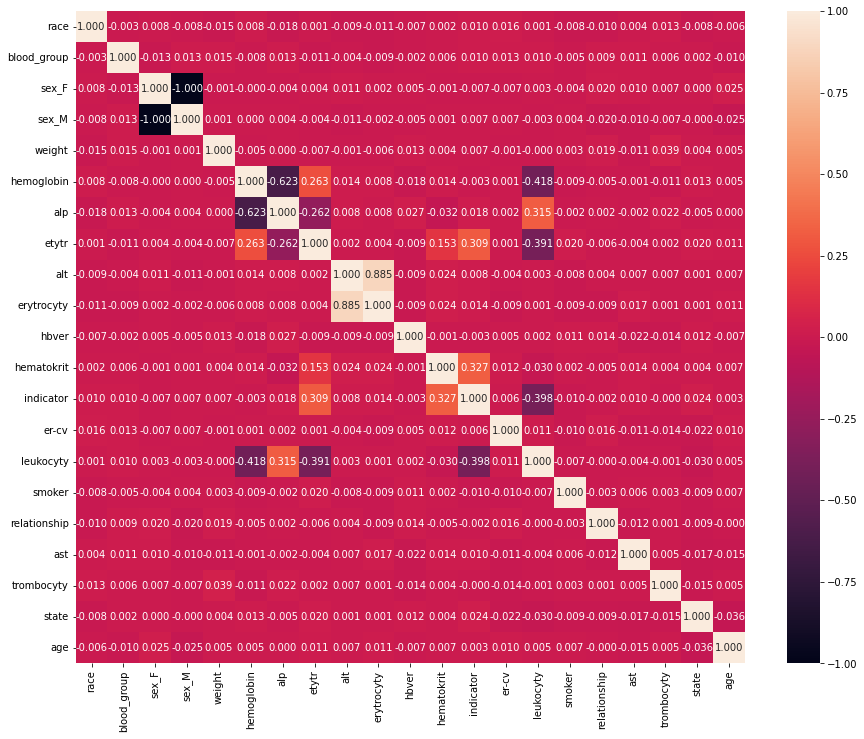

In [50]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_replacedOut.corr(), ax=ax, annot=True, fmt=".3f")

In [51]:
merged_num_only.corr() - merged_replacedOut.corr()

,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
race,0.000000,-0.004958,0.001256,-0.001256,-0.003661,-0.001836,-0.000639,0.000872,-0.000878,-0.000305,...,0.002471,0.000606,0.002849,0.000375,0.000159,-0.000328,0.000567,0.002278,-0.000542,0.003081
blood_group,-0.004958,0.000000,0.000000,0.000000,0.000513,0.001078,0.000118,0.000042,0.009963,0.002709,...,0.000748,0.000000,-0.000485,0.001165,0.000000,0.000000,-0.000082,-0.000944,-0.000978,-0.000209
sex_F,0.001256,0.000000,0.000000,0.000000,-0.000308,-0.000987,-0.000026,0.001522,0.008403,0.002597,...,-0.004113,0.000000,-0.000123,-0.001090,0.000000,0.000000,-0.000744,-0.000789,-0.000769,-0.000526
sex_M,-0.001256,0.000000,0.000000,0.000000,0.000308,0.000987,0.000026,-0.001522,-0.008403,-0.002597,...,0.004113,0.000000,0.000123,0.001090,0.000000,0.000000,0.000744,0.000789,0.000769,0.000526
weight,-0.003661,0.000513,-0.000308,0.000308,0.000000,-0.001401,-0.000416,0.000227,0.001021,0.000463,...,0.000694,0.000409,-0.000812,0.003356,-0.000233,-0.001617,0.003349,-0.003844,-0.001696,0.000102
hemoglobin,-0.001836,0.001078,-0.000987,0.000987,-0.001401,0.000000,0.067983,-0.003145,-0.006682,-0.000446,...,0.005089,0.002842,-0.002307,0.009191,-0.002590,-0.000361,0.001672,0.002441,0.000727,0.000006
alp,-0.000639,0.000118,-0.000026,0.000026,-0.000416,0.067983,0.000000,0.020227,0.005948,0.001783,...,0.005858,0.000377,0.001528,-0.004638,0.000356,0.000073,-0.000490,-0.001075,0.000459,-0.000460
etytr,0.000872,0.000042,0.001522,-0.001522,0.000227,-0.003145,0.020227,0.000000,-0.011989,-0.002535,...,0.018334,-0.006553,0.001859,0.036345,0.000612,-0.000858,-0.000849,0.000727,-0.002366,0.000979
alt,-0.000878,0.009963,0.008403,-0.008403,0.001021,-0.006682,0.005948,-0.011989,0.000000,-0.118589,...,-0.001048,-0.005677,0.008685,0.002509,0.015574,-0.005308,0.006143,-0.004103,0.008821,-0.008617
erytrocyty,-0.000305,0.002709,0.002597,-0.002597,0.000463,-0.000446,0.001783,-0.002535,-0.118589,0.000000,...,-0.001619,-0.001495,0.003481,0.001900,0.002084,-0.002745,0.000689,-0.001806,-0.000416,-0.002160


### Váha

In [52]:
merged_num_only_weight = merged_num_only.copy()

In [53]:
merged_num_only_weight["weight"].describe()

count    9672.000000
mean       70.018284
std        34.907851
min       -54.420260
25%        45.971097
50%        69.718325
75%        93.812853
max       196.504820
Name: weight, dtype: float64

<AxesSubplot:>

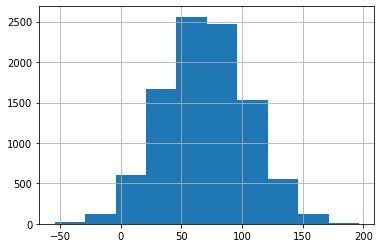

In [54]:
merged_num_only_weight["weight"].hist()

In [55]:
merged_num_only_weight2 = merged_num_only_weight.copy()
q05, q95 = percentile(merged_num_only_weight2["weight"], 5), percentile(merged_num_only_weight2["weight"], 95)
merged_num_only_weight2["weight"] = np.where(merged_num_only_weight2["weight"] < q05, q05, merged_num_only_weight2["weight"])
merged_num_only_weight2["weight"] = np.where(merged_num_only_weight2["weight"] > q95, q95, merged_num_only_weight2["weight"])

<AxesSubplot:>

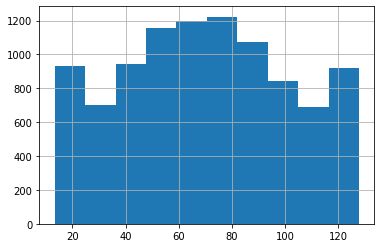

In [56]:
merged_num_only_weight2["weight"].hist()

In [57]:
merged_num_only_weight["weight"] = abs(merged_num_only_weight["weight"])

In [58]:
merged_num_only_weight["weight"].describe()

count    9672.000000
mean       70.555391
std        33.808981
min         0.045640
25%        45.981280
50%        69.718325
75%        93.812853
max       196.504820
Name: weight, dtype: float64

<AxesSubplot:>

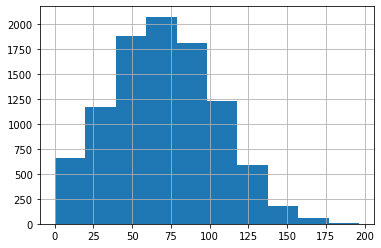

In [59]:
merged_num_only_weight["weight"].hist()

### Záver integrácie a čistenia dát

Chýbajúcich dát je celkovo 330. Pri stĺpcoch ktoré majú 10000+ záznamov to je irelevantné číslo. Chýbajúce dáta tvoria iba 3,3% dát, preto je bezpečné ich odstrániť s minimálnou hrozbou výrazného ovplyvnenia výsledkov. Vyskúšali sme nahradiť chýbajúce hodnoty priemerom, mediánom a kNN, ale zmeny v koreláciách boli minimálne. Preto sme sa rozhodli naďalej pokračovať s datasetom z ktorého vychýlené hodnoty odstránime.

Vychýlené hodnoty sú prítomné, ide ale o medicínske dáta ľudí s rôznym zdravotným stavom. To, či sú nejaké hodnoty z krvných testov nezmyselné, nedokážeme posúdiť z dôvodu nedostatku doménových znalostí. Vyskúšali sme vychýlené dáta odstrániť, prípadne ich nahradiť hraničnými hodnotami rozdelenia (5% resp. 95%). Zmeny v koreláciách boli prítomné, avšak podľa nášho názoru manipulácia s výchýlenými dátami nie je bezpečná, keďže nevieme, či sú dáta vychýlené z dôvodu chyby, alebo z dôvodu skutočne vychýlenej hodnoty. Naďalej budeme predpolkadať, že dáta sú vychýlené preto, lebo boli tak namerané aj v skutočnosti. Preto ich nebudeme odstraňovať ani nahrádzať. 

Ďalej budeme pracovať s dátami, kde boli chýbajúce dáta odstránené a vychýlené hodnoty neboli nijako ošetrené. V *merged_withoutNA* sa nachádzajú všetky dáta z *merged* a NA hodnoty sú odstránené. V *merged_num_only* sa nachádzajú všetky dáta z *merged_withoutNA* s tým, že sú odstránené nenumerické stĺpce *residence, job, company, name, birthdate*.

## 2. Realizácia predspracovania dát (5b)


* Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test mergedset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím mergedsetom.
* Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

### Kódovanie kategorických atribútov pre strojové učenie

Vykonali sme to na začiatku pre zjednodušenie práce.

### Transformácia atribútov pre strojové učenie

#### Transfromácia na normálne rozdelenie ("make data more Gaussian")

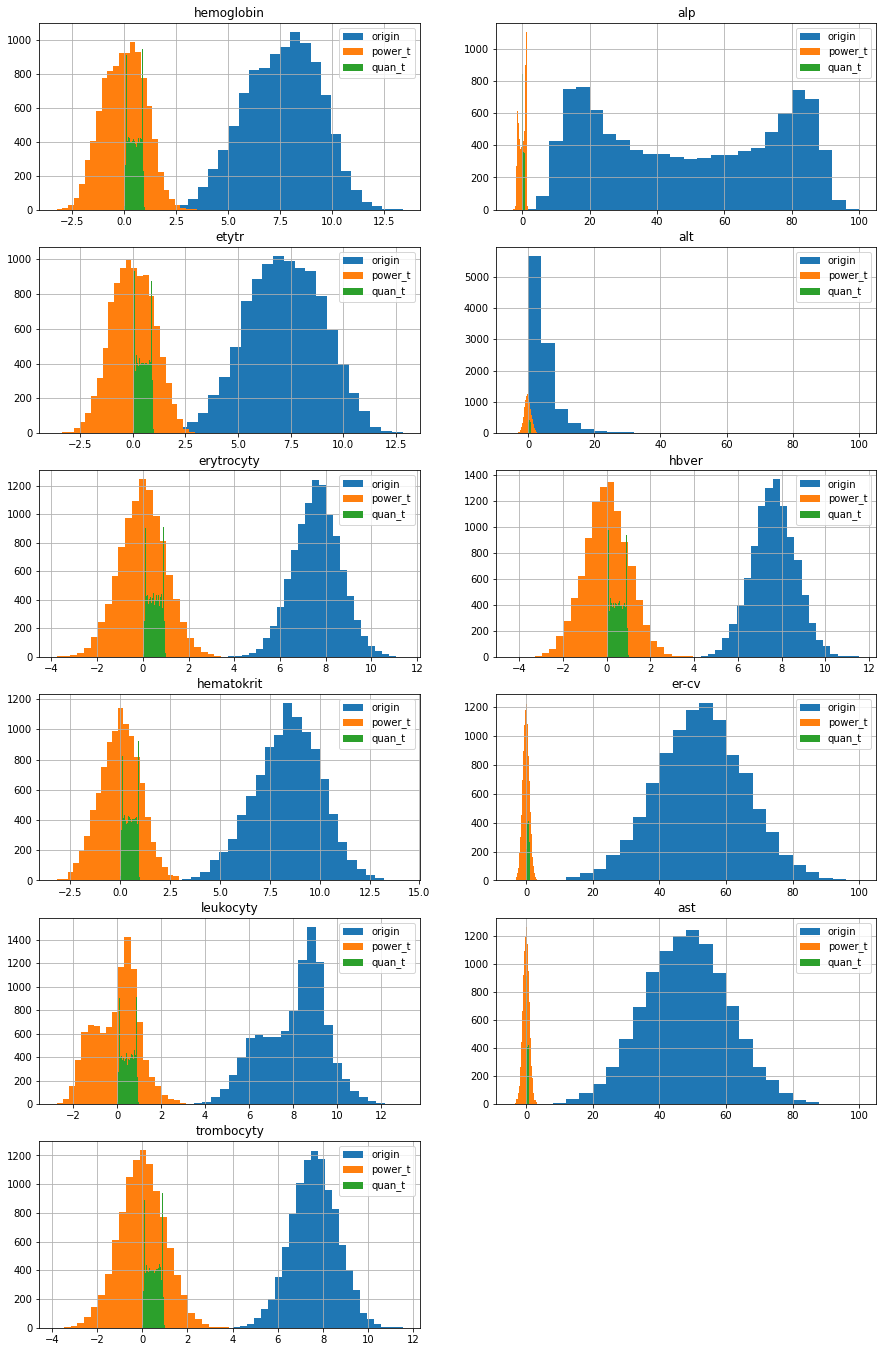

In [60]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
quan = QuantileTransformer(n_quantiles=10, random_state=0)

m_col = ['hemoglobin', 'alp', 'etytr', 'alt', 'erytrocyty', 'hbver', 'hematokrit', 'er-cv', 'leukocyty', 'ast', 'trombocyty']
fig, axs = plt.subplots(2, 2, figsize=(15,24))
for num, col_name in enumerate(m_col):
    plt.subplot(6, 2, num+1)
    plt.hist(merged[col_name], bins=25)
    pow_trans = power.fit_transform(merged[[col_name]])
    plt.hist(pow_trans, bins=25)
    q_trans = quan.fit_transform(merged[[col_name]])
    plt.hist(q_trans, bins=25)
    plt.grid()
    plt.title(col_name)
    plt.legend(['origin', 'power_t', 'quan_t'])

Podľa grafov vidno, že power transformácia pomohla dáta upraviť na normálny tvar ako napr. pre atribút alt. Naopak quantile transformácia nebola veľmi užitočná a dokonca ešte aj v niektorých prípadoch normálne rozdelenie pokazila.

#### Škálovanie dát

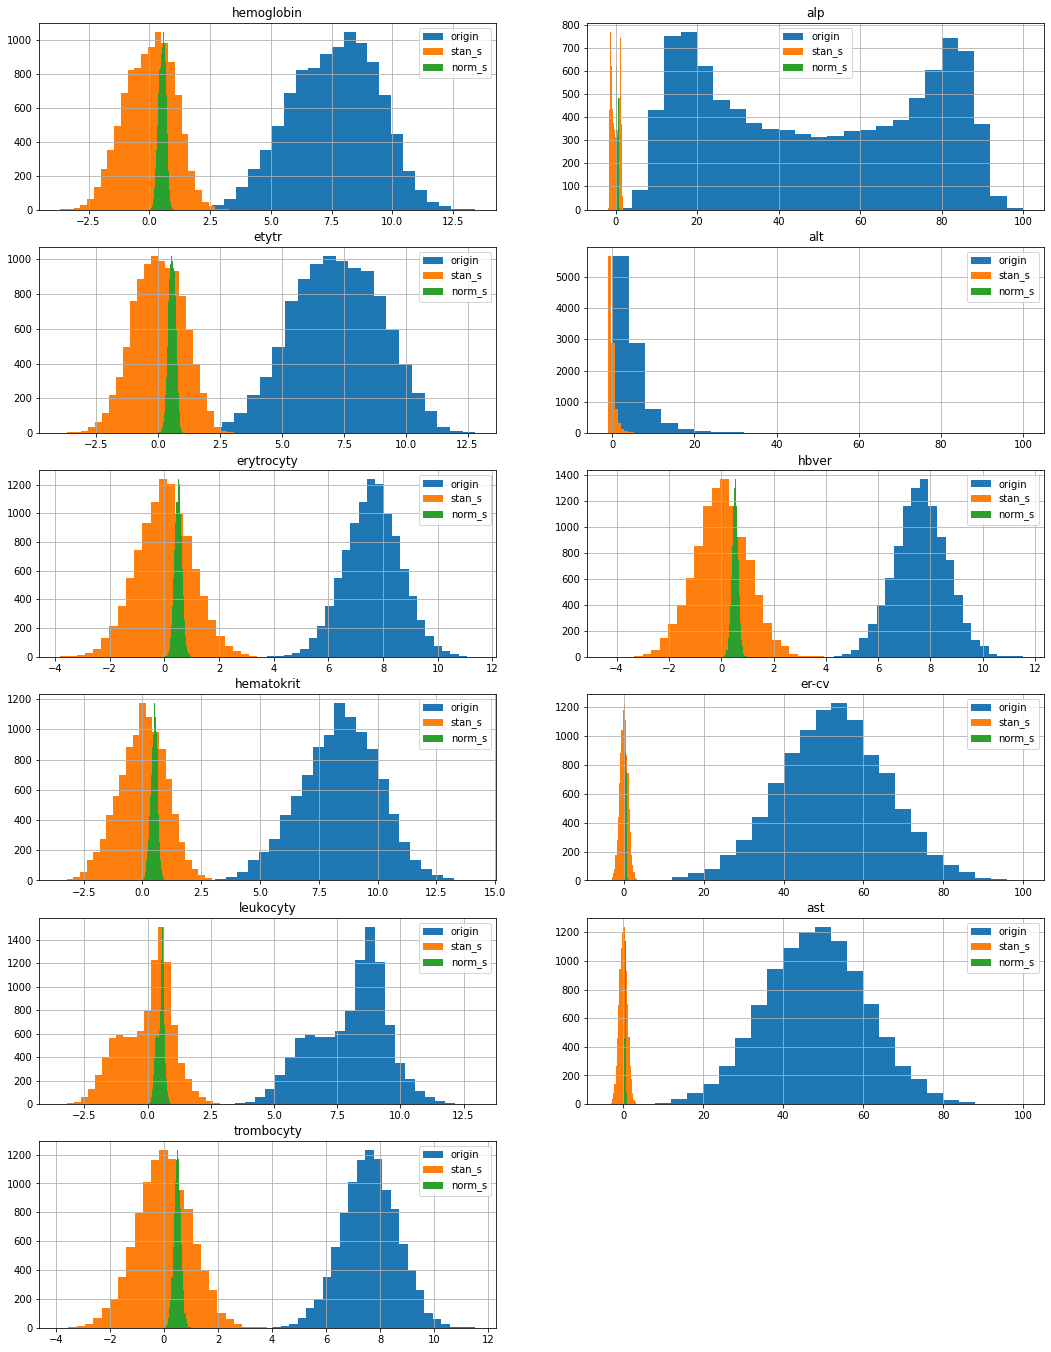

In [61]:
stan_s = StandardScaler()
norm_s = MinMaxScaler()

m_col = ['hemoglobin', 'alp', 'etytr', 'alt', 'erytrocyty', 'hbver', 'hematokrit', 'er-cv', 'leukocyty', 'ast', 'trombocyty']
fig, axs = plt.subplots(2, 2, figsize=(18,24))
for num, col_name in enumerate(m_col):
    plt.subplot(6, 2, num+1)
    plt.hist(merged[col_name], bins=25)
    s_scaled = stan_s.fit_transform(merged[[col_name]])
    plt.hist(s_scaled, bins=25)
    n_scaled = norm_s.fit_transform(merged[[col_name]])
    plt.hist(n_scaled, bins=25)
    plt.grid()
    plt.title(col_name)
    plt.legend(['origin', 'stan_s', 'norm_s'])


Ani jedno škálovanie atribútu alt neupravilo dostatočne hodnoty voči ostatným atribútom.

### Rozdelenie na trénovaciu a testovaciu množinu

Dataset merged rozdelíme v pomere 1/3 pre testovaciu množinu a 2/3 pre trénovaciu množinu pre indikátor (y) a pre všetky ostatné atribúty (X).

In [62]:
X_train, X_test, y_train, y_test = train_test_split(merged.drop(["indicator"], axis=1), merged['indicator'], test_size=0.33)

### Záver realizácie predspracovania dát 

Kategorické dáta sme zakódovali, resp. transformovali dvoma spôsobmi, Ordinal a One-hot. One-hot sme použili pre pohlavie, kde pri dvoch typoch atribútov ide o rozumné rozšírenie tabuľkových dát. Vďaka tomuto rozdeleniu bude možné hneď pozorovať vplyv pohlavia na stav pacienta. Ostatné všetky kategorické atribúty sme transformovali pomocou Ordinal. Ide o klasický spôsob, ktorým sme mohli rozdeliť väčšiu základnú množinu typov dát. Pre strojové učenie by bolo vhodnejšie, keby každá hodnota kategorického atribútu mala samostatný stĺpec s binárnou hodnotou, ale to by príliš drasticky zvýšilo počet stĺpcov. Pre zachovanie prehľadnosti teda používame Ordinal.

Niektoré spôsoby (napr. binary encoding) sme kvôli rôznorodosti nepoužili, lebo by vzniklo príliš veľa redundantných stĺpcov. Alebo iné spôsoby (napr. leave one out) neboli pre nás zaujímave.

Škálovanie dát dopadlo predvídateľne. Vyskúšali sme MinMaxScaler a StandardScaler. Dalo sa očakávať, že dáta boli preškálované okolo základného rozsahu, ale ani jeden spôsob nevyriešil problém s vychýlenými hodnotami pre atribút alt, preto sme sa rozhodli tento typ predspracovania nepoužiť.

Transformáciu číselných dát, aby sa viac podobali Gaussovmu rozdeleniu, sme v našej práce tiež vyskúšali. Ako vidno v grafoch Quantile Transformer tiež nebol užitočný, a dokonca pokazil niektoré rozdelenia. Power Transformer upravil hodnoty atribútu alt a priblížil rozdelenie k normálnemu rozdeleniu a aj početnosť je v približne rovnakom rozsahu ako je to u ostatných atribútov. Kvôli výstpu transformácie podľa dát sme sa rozhodli vybrať si práve Power Transformer pre ďalšie pracovanie a realizáciu.


## 3. Výber atribútov pre strojové učenie (5b)

* Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

In [63]:
X = merged_num_only_weight.drop(["indicator"], axis=1)
y = merged_num_only_weight.indicator

Vzhľadom na to, že indikátor používame ako target množinu, z dát ho odstraňujeme.

### Variance Threshold

Pred výberom atribútov vyskúšame odstrániť atribúty s nízkou varianciou, konkrétne ak zhoda je v 80% a viac vzorkách.

In [64]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
colsVT = sel.fit_transform(X)
colsVT[0].size

20

Výsledok ukazuje počet stĺpcov pre jedno pozorovanie (jeden riadok v Data frame). Pred týmto krokom bolo dokopy atribútov 20, takže to znamená, že v dátach nemáme atribúty s príliš nízkou varianciou a teda nie sú až dostatočne výpovedné.

### Výber K najlepších (SelectKBest)
Výber je založený na tom, že vyberie k najlepších výsledkov. Preto sme pomocou funkcie selectKbestToDf() vybrali i najlepších a pomocou funkcie orderColumns() sme zoradili získané výsledky.

In [65]:
def orderColumns(X, y, typeOfSelection):
    selector = SelectKBest(typeOfSelection, k ='all')
    X_selected = selector.fit_transform(X, y)
    scores = selector.scores_
    column_names = X.columns[selector.get_support()]
    indices = [x for _,x in sorted(zip(scores,column_names), reverse=True)]
    
    return indices

#### Typy skórovacích funkcií:
##### 1. mutual_info_regression

In [66]:
MI_column_order = orderColumns(X, y, mutual_info_regression)
print(MI_column_order)

['leukocyty', 'hematokrit', 'etytr', 'sex_M', 'weight', 'ast', 'hemoglobin', 'alt', 'hbver', 'alp', 'erytrocyty', 'er-cv', 'trombocyty', 'state', 'smoker', 'sex_F', 'relationship', 'race', 'blood_group', 'age']


##### 2. chi2

In [67]:
Chi2_column_order = orderColumns(X, y, chi2)
print(Chi2_column_order)

['etytr', 'leukocyty', 'hematokrit', 'state', 'alp', 'weight', 'ast', 'age', 'blood_group', 'race', 'er-cv', 'smoker', 'alt', 'sex_M', 'sex_F', 'erytrocyty', 'hbver', 'relationship', 'trombocyty', 'hemoglobin']


##### 3. f_regression

In [68]:
Fv_column_order = orderColumns(X, y, f_regression)
print(Fv_column_order)

['leukocyty', 'hematokrit', 'etytr', 'state', 'alp', 'erytrocyty', 'ast', 'race', 'blood_group', 'smoker', 'sex_F', 'sex_M', 'weight', 'er-cv', 'hbver', 'age', 'alt', 'relationship', 'trombocyty', 'hemoglobin']


### Výber podľa percentilu (SelectPercentile)
Výber je založený na tom, že podľa percentilu vyberie n najlepších výsledkov. Preto sme pomocou funkcie selectPercentileToDf() vybrali i najlepších a pomocou funkcie orderColumnsPrc() sme zoradili získané výsledky.

In [69]:
def orderColumnsPrc(X, y, estimator):
    selector = SelectPercentile(estimator, percentile=100)
    X_selected = selector.fit_transform(X, y)
    scores = selector.scores_
    column_names = X.columns[selector.get_support()]
    indices = [x for _,x in sorted(zip(scores,column_names), reverse=True)]
    
    return indices

#### Typy skórovacích funkcií:
##### 1. chi2

In [70]:
PrcCH_column_order = orderColumnsPrc(X, y, chi2)
print(PrcCH_column_order)

['etytr', 'leukocyty', 'hematokrit', 'state', 'alp', 'weight', 'ast', 'age', 'blood_group', 'race', 'er-cv', 'smoker', 'alt', 'sex_M', 'sex_F', 'erytrocyty', 'hbver', 'relationship', 'trombocyty', 'hemoglobin']


##### 2. f_classif

In [71]:
PrcFCL_column_order = orderColumnsPrc(X, y, f_classif)
print(PrcFCL_column_order)

['leukocyty', 'hematokrit', 'etytr', 'state', 'alp', 'erytrocyty', 'ast', 'race', 'blood_group', 'smoker', 'sex_M', 'sex_F', 'weight', 'er-cv', 'hbver', 'age', 'alt', 'relationship', 'trombocyty', 'hemoglobin']


##### 3. f_regression

In [72]:
PrcFRE_column_order = orderColumnsPrc(X, y, f_regression)
print(PrcFRE_column_order)

['leukocyty', 'hematokrit', 'etytr', 'state', 'alp', 'erytrocyty', 'ast', 'race', 'blood_group', 'smoker', 'sex_F', 'sex_M', 'weight', 'er-cv', 'hbver', 'age', 'alt', 'relationship', 'trombocyty', 'hemoglobin']


### Výber z modelu (SelectFromModel)
Vyberajú sa atribúty, ktoré sú najlepšie podľa estimátora. Ukážeme výber podľa RandomForestClassifier, ktorým sa vyberajú stromovým spôsobom tie hodnoty, ktoré nie sú irelevantné.

In [73]:
selectorSFM = SelectFromModel(RandomForestClassifier())
SFM_selected = selectorSFM.fit_transform(X, y)
column_names = X.columns[selectorSFM.get_support()]
pd.DataFrame(SFM_selected, columns = column_names).columns

Index(['hemoglobin', 'alp', 'etytr', 'hematokrit', 'leukocyty'], dtype='object')

**Na záver** sme z atribútov získaných z metód výberu atribútov (K najlepších a podľa percentilu) ohodnotili ich poradie, aby sme vytvorili poradie najdôležitejších atribútov celkovo.

In [74]:
def orderLists(X, list_of_list):
    x_columns = X.columns
    x_weights = [0 for i in range(len(x_columns))]
    for lst in list_of_list:
        for i in range(len(x_columns)):
            x_weights[i] += lst.index(x_columns[i])         
    map_of_cols = [q for _, q in sorted(zip(x_weights, x_columns))]
    return map_of_cols    

In [75]:
list_of_list = [MI_column_order, Chi2_column_order, Fv_column_order, PrcCH_column_order, PrcFCL_column_order, PrcFRE_column_order]
orderLists(X, list_of_list)

['leukocyty',
 'etytr',
 'hematokrit',
 'state',
 'alp',
 'ast',
 'weight',
 'erytrocyty',
 'race',
 'blood_group',
 'sex_M',
 'smoker',
 'er-cv',
 'sex_F',
 'age',
 'alt',
 'hbver',
 'hemoglobin',
 'relationship',
 'trombocyty']

### Záver výberu atribútov pre strojové učenie

Vyskúšali sme viacero metód na výber atribútov strojového učenia. Každou z týchto metód sme vytvorili poradie atribútov podľa dôležitosti a následne sme tieto atribúty zoradili celkovo.

Výsledné poradie ktoré nám vrátila naša hodnotiaca funkcia:

*'leukocyty', 'etytr', 'hematokrit','state', 'alp', 'ast', 'weight', 'erytrocyty', 'race', 'blood_group', 'age', 'smoker', 'er-cv', 'sex_M', 'sex_F', 'alt', 'hbver', 'relationship', 'hemoglobin', 'trombocyty'*

Ako vidíme, hodnoty 'leukocyty', 'etytr' a 'hematokrit' sú najdôležitejšie. Prekapivo, atribút 'state' sa taktiež umiestnil pomerne vysoko. Môže to byť spôsobené použitím Ordinal encodingom kategorických dát. Preto k tomuto atribútu pristupujeme zdržanlivo. Rovnako, ako k podobným kategorickám atribútom, ako 'blood_group', 'race' a 'relationship'. V nasledujúcej fáze projektu na základe krížovej validácie overíme, či je vplyv kategorických atribútov dôležitý, alebo nie.

Hoci atrubút 'weight' sa javí ako pomerne dôležitý, vzhľadom na našu doménovú znalosť ľudskej váhy, rozhodli sme sa tento atribút pre jeho neobyčajné hodnoty úplne vyradiť.

## 4. Replikovateľnosť predspracovania (5b)

* Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
* Očakáva sa aj využitie možnosti sklearn.pipeline

### Importy

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats

import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Predspracovanie z fázy 1

In [40]:
def phase1():
    labor = pd.read_csv("046/labor.csv", sep='\t')
    labor.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
    labor = labor.drop(["index", "name"], axis=1)
    smoker_encoding = {"Y": 1, "N": 0, "yes": 1, "no": 0}
    labor["smoker"].replace(smoker_encoding, inplace=True)

    profiles = pd.read_csv("046/profiles.csv", sep='\t')
    profiles.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
    profiles = profiles.drop(["index"], axis=1)
    profiles["race"].replace({"black": "Black", "white": "White", "blsck": "Black"}, inplace=True)
    profiles["birthdate"] = pd.to_datetime(profiles['birthdate'], utc=False)

    merged = pd.merge(profiles, labor, how='outer', on='ssn')
    merged = merged.drop(["ssn"], axis=1)
    return merged

### 2.1 Integrácia a čistenie dát

In [41]:
class handleNA(TransformerMixin):
    def __init__(self, method, strategy=None):
        self.method = method
        self.strategy = strategy
        
    def removeNA(self, merged):
        return merged.dropna()

    def getNAcols(self, merged):
        return merged.columns[merged.isnull().any()].tolist()

    def replaceNaN(self, original_merged):
        na_cols = self.getNAcols(original_merged)
        strategy = self.strategy
        new_merged = original_merged.copy()
        if strategy == "kNN":
            imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    #         imp_strategy = KNNImputer()
        elif strategy == "mean" or strategy == "median":    
            imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
        else:
            raise Exception("Unsupported strategy")
        for col in na_cols:
            new_merged[col] = imp_strategy.fit_transform(new_merged[[col]])
        return new_merged
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'nothing':
            return X
        elif self.method == 'remove':
            return self.removeNA(X);
        elif self.method == 'replace':
            return self.replaceNaN(X)
        else:
            raise Exception("Unsupported method")

In [42]:
class handleOutliers(TransformerMixin):
    def __init__(self, method):
        self.method = method
        
    def onlyNumCols(self, merged):
        return merged.drop(["residence", "job", "company", "name", "birthdate"], axis=1, errors='ignore')

    def identify_outliers(self, merged):
        suma = 0;
        for col in merged.columns:
            q25, q75 = percentile(merged[col], 25), percentile(merged[col], 75)
            iqr = q75 - q25
            cut_off = iqr * 1.5
            lower, upper = q25 - cut_off, q75 + cut_off
            outliers = merged[((merged[col] < lower) | (merged[col] > upper))] 
            print(col, 'Identified outliers: %d' % len(outliers))
            suma += len(outliers)
        print('Sum of identified outliers: %d' % suma)

    def remove_outliers(self, merged):
        newMerged = merged.copy()
        for col in newMerged.columns:
            q25, q75 = percentile(newMerged[col], 25), percentile(newMerged[col], 75)
            iqr = q75 - q25
            cut_off = iqr * 1.5
            lower, upper = q25 - cut_off, q75 + cut_off
            newMerged = newMerged[((newMerged[col] >= lower) & (newMerged[col] <= upper))] 
        return newMerged

    def replace_outliers(self, merged):
        newMerged = merged.copy()
        for col in newMerged.columns:
            q05, q95 = percentile(newMerged[col], 5), percentile(newMerged[col], 95)
            newMerged[col] = np.where(newMerged[col] < q05, q05, newMerged[col])
            newMerged[col] = np.where(newMerged[col] > q95, q95, newMerged[col])
        return newMerged
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'nothing':
            return self.onlyNumCols(X)
        elif self.method == 'remove':
            return self.remove_outliers(self.onlyNumCols(X))
        elif self.method == 'replace':
            return self.replace_outliers(self.onlyNumCols(X))
        else:
            raise Exception("Unsupported method")

### 2.2 Realizácia predspracovania dát

In [43]:
class handleCategorical(TransformerMixin):
    def transformResidenceNLP(self, merged):
        for i in merged['residence'].index:
            country_code = re.findall('[A-Z]{2} [0-9]{5}', str(merged['residence'][i]))[0]
            merged.at[i, 'state']=re.findall('[A-Z]{2}', country_code)[0]
        len(merged['state'].value_counts())
        return merged.drop('residence', axis=1)

    def encodeOrdinal(self, merged):
        transformed = self.transformResidenceNLP(merged)
        ce_ordinal = ce.OrdinalEncoder(cols=['race', 'state', 'blood_group', 'relationship'])
        encoded = ce_ordinal.fit_transform(transformed)
        return encoded

    def frombirthtoage(self, born):
        now = datetime.date.today()
        return now.year - born.year - ((now.month, now.day) < (born.month, born.day))

    def computeAge(self, merged):
        ages = merged['birthdate'].apply(lambda d: self.frombirthtoage(d))
        merged = merged.assign(age=ages.values)
        return merged.drop('birthdate', axis=1)

    def encodeOneHot(self, merged):
        ce_OHE = ce.OneHotEncoder(cols=['sex'], use_cat_names=True)
        merged = ce_OHE.fit_transform(merged)
        return merged

    def fit(self, X):
        return self
    
    def transform(self, X):
        new_data = self.encodeOrdinal(X)
        new_data = self.computeAge(new_data)
        new_data = self.encodeOneHot(new_data)    
        return new_data

In [44]:
class handleTransformations(TransformerMixin):
    def __init__(self, method):
        self.method = method
        
    def transformPower(self, merged):
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        df_return = pd.DataFrame(power.fit_transform(merged), columns = merged.columns)
        return df_return
    
    def transormQuan(self, merged):
        quan = QuantileTransformer(n_quantiles=10, random_state=0)
        df_return = pd.DataFrame(quan.fit_transform(merged), columns = merged.columns)
        return df_return
    
    def scaleMM(self, merged):
        norm_s = MinMaxScaler()
        df_return = pd.DataFrame(norm_s.fit_transform(merged), columns = merged.columns)
        return df_return
        
    def scaleS(self, merged):
        stan_s = StandardScaler()
        df_return = pd.DataFrame(stan_s.fit_transform(merged), columns = merged.columns)
        return df_return
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'nothing':
            return X
        elif self.method == 'power':
            return self.transformPower(X)
        elif self.method == 'quan':
            return self.transormQuan(X)
        elif self.method == 'minmax':
            return self.scaleMM(X)
        elif self.method == 'standard':
            return self.scaleS(X)
        else:
            raise Exception("Unsupported method")

### 2.3 Výber atribútov pre strojové učenie

In [45]:
def orderColumns(X, y, typeOfSelection):
    selector = SelectKBest(typeOfSelection, k ='all')
    X_selected = selector.fit_transform(X, y)
    scores = selector.scores_
    column_names = X.columns[selector.get_support()]
    indices = [x for _,x in sorted(zip(scores,column_names), reverse=True)]
    
    return indices

In [46]:
def orderColumnsPrc(X, y, estimator):
    selector = SelectPercentile(estimator, percentile=100)
    X_selected = selector.fit_transform(X, y)
    scores = selector.scores_
    column_names = X.columns[selector.get_support()]
    indices = [x for _,x in sorted(zip(scores,column_names), reverse=True)]
    
    return indices

In [47]:
def orderLists(X, list_of_list):
    x_columns = X.columns
    x_weights = [0 for i in range(len(x_columns))]
    for lst in list_of_list:
        for i in range(len(x_columns)):
            x_weights[i] += lst.index(x_columns[i])         
    map_of_cols = [q for _, q in sorted(zip(x_weights, x_columns))]
    return map_of_cols   

In [48]:
class handleSelection(TransformerMixin):
    def __init__(self, list_attributes):
        self.list_attributes = list_attributes
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.list_attributes == 'all':
            return X
        else:
            return X[self.list_attributes]

### Pipeline

In [49]:
def pipelineGenerator(na_method='remove', na_strategy=None, outliers_method='nothing', 
                      tranformation_method='nothing', select_attributes='all'):
    pipeline =  Pipeline([
        ('handleCategorical', handleCategorical()),
        ('handleNA', handleNA(na_method, na_strategy)), # possible: 'nothing'; 'remove'; 'replace', 'mean'; 'replace', 'median'; 'replace', 'kNN'
        ('handleOutliers', handleOutliers(outliers_method)), # possible: 'nothing'; 'remove'; 'replace'
        ('handleTransformations', handleTransformations(tranformation_method)), # possible: 'nothing'; 'power'; 'quan'; 'minmax'; 'standard'
        ('handleSelection', handleSelection(select_attributes)) # possible: 'all'; list of attributes
    ])
    return pipeline

In [50]:
original_data = phase1()
pipeline1 = pipelineGenerator()
transformed_data1 = pipeline1.fit_transform(original_data)
transformed_data1

,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age
0,1,1,1,0,68.64852,7.26815,68.18352,5.81889,2.66285,6.93051,...,11.27999,0.0,44.47642,8.86713,0,1,26.77151,5.62532,1,14
1,1,1,1,0,39.27363,5.09400,58.42059,5.99564,1.43578,6.54612,...,11.65206,1.0,57.12059,10.57140,0,2,38.28069,6.59275,1,14
2,1,1,1,0,61.21115,9.10298,14.51194,10.27253,2.13866,6.91541,...,9.13539,1.0,16.95110,7.30150,0,3,52.93857,8.58363,1,14
3,1,1,1,0,121.34568,9.03854,11.04396,5.55113,1.35987,6.49755,...,8.46192,0.0,63.86999,8.47060,0,3,48.94005,7.28386,1,14
4,2,2,1,0,107.36307,7.43673,68.85609,5.90077,3.45904,7.88035,...,5.96198,1.0,42.66862,6.25355,0,4,60.53571,9.03697,2,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,4,2,0,1,63.91329,6.92457,76.04985,7.79662,2.68857,7.37201,...,11.49758,1.0,54.27312,6.04988,0,3,29.80578,6.04777,37,77
9998,4,2,0,1,133.06279,5.38773,72.42292,5.45882,5.27736,7.99408,...,7.48688,1.0,56.61539,8.62062,1,5,72.76467,7.53086,37,77
9999,4,4,1,0,38.38421,9.21934,13.81263,4.16461,2.24489,6.34525,...,7.06649,1.0,34.61849,6.56510,1,2,27.22654,8.20851,40,99
10000,4,4,1,0,93.21841,9.55404,14.37022,8.41723,14.07623,9.32920,...,7.25001,1.0,65.83218,6.51575,0,1,34.02137,9.31013,40,99


In [51]:
list_attributes = ['leukocyty', 'etytr', 'hematokrit','state', 'alp']
pipeline2 = pipelineGenerator(na_method='replace', na_strategy='mean', outliers_method='replace', 
                              tranformation_method='power', select_attributes=list_attributes)
transformed_data2 = pipeline2.fit_transform(original_data)
transformed_data2

C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,leukocyty,etytr,hematokrit,state,alp
0,0.575148,-0.822680,1.762792,-1.790999,0.762040
1,1.741017,-0.716693,1.762792,-1.790999,0.449045
2,-0.649794,1.706577,0.471032,-1.790999,-1.427225
3,0.237190,-0.983557,0.016238,-1.790999,-1.595630
4,-1.311161,-0.773561,-1.585082,-1.790999,0.782842
...,...,...,...,...,...
9997,-1.425585,0.354780,1.762792,0.690496,0.999915
9998,0.362799,-1.039110,-0.625331,0.690496,0.891675
9999,-1.127353,-1.816919,-0.895445,0.862978,-1.470309
10000,-1.157182,0.720815,-0.778025,0.862978,-1.435884


Úpravy dát z fázy jedna sme vložili do jednej samostatnej funkcie. Úpravy dát z bodov 2.1 a 2.2, 2.3 sme rozdelili do tried tak, aby boli volateľné z pipeline s rôznymi argumentami. Na základe toho dokážeme upraviť dataset podľa svojich predstáv.

### Export do CSV

In [66]:
def pipetofile(transformed_data, X_train, X_test, y_train, y_test):
    X_train.to_csv('processed_data_after_phase_2_X_train.csv', sep='\t')
    X_test.to_csv('processed_data_after_phase_2_X_test.csv', sep='\t')
    y_train.to_csv('processed_data_after_phase_2_y_train.csv', sep='\t')
    y_test.to_csv('processed_data_after_phase_2_y_test.csv', sep='\t')

In [67]:
original_data = phase1()
pipeline1 = pipelineGenerator()
transformed_data = pipeline1.fit_transform(original_data)

X_train, X_test, y_train, y_test = train_test_split(transformed_data.drop(["indicator"], axis=1), transformed_data['indicator'], test_size=0.33)
pipetofile(pipeline1, X_train, X_test, y_train, y_test)

In [68]:
len(X_train)

6480

In [69]:
len(y_train)

6480

In [70]:
len(X_test)

3192

In [71]:
len(y_test)

3192

Upravený dataframe ktorý je výstupom z pipeline ukladáme do csv súboru.

Správa sa odovzdáva v 9. týždni semestra

Na cvičení, dvojica svojmu cvičiacemu odprezentuje vykonanú prieskumnú analýzu v Jupyter Notebooku.
Správu elektronicky odovzdá jeden člen z dvojice do systému AIS do nedele 21.11.2021 23:59.